In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

### Приближение стационарного ряда "Avocado Prices"

In [7]:
def test_stationarity(timeseries):
    df_test = adfuller(timeseries, autolag='AIC')
    print('Results of Dickey-Fuller Test:')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in df_test[4].items():
        df_output['Critical Value (%s)' % key] = value
    print(df_output)

In [8]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                -7.449624e+00
p-value                        5.716069e-11
#Lags Used                     4.500000e+01
Number of Observations Used    1.820300e+04
Critical Value (1%)           -3.430709e+00
Critical Value (5%)           -2.861699e+00
Critical Value (10%)          -2.566855e+00
dtype: float64


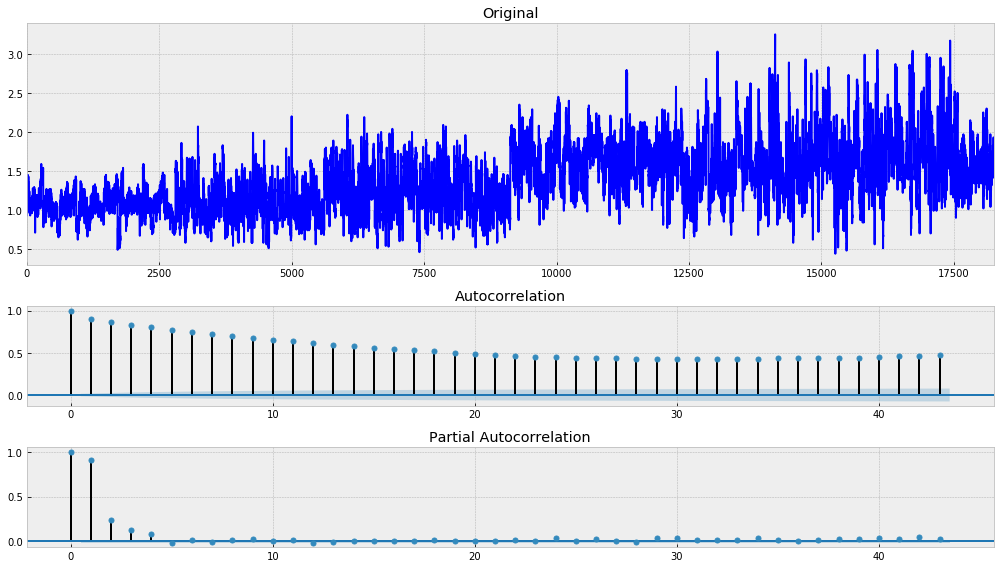

In [13]:
series = pd.read_csv("Series/avocado.csv")['AveragePrice']
tsplot(series)

In [14]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                   -34.418024
p-value                            0.000000
#Lags Used                        45.000000
Number of Observations Used    18202.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861699
Critical Value (10%)              -2.566855
dtype: float64


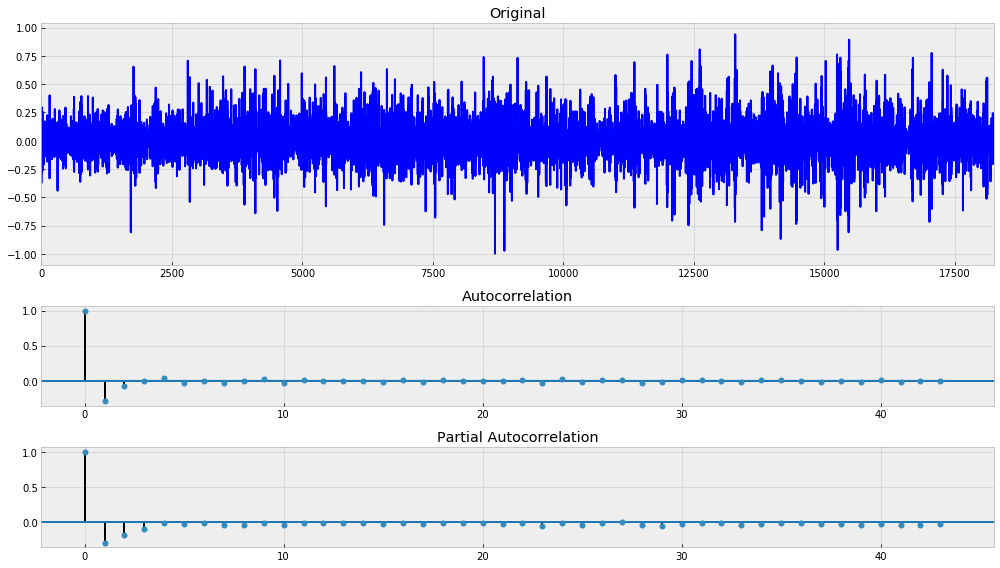

In [15]:
tsplot(series)

Ряд сделали стационарным, можно делать приближение.

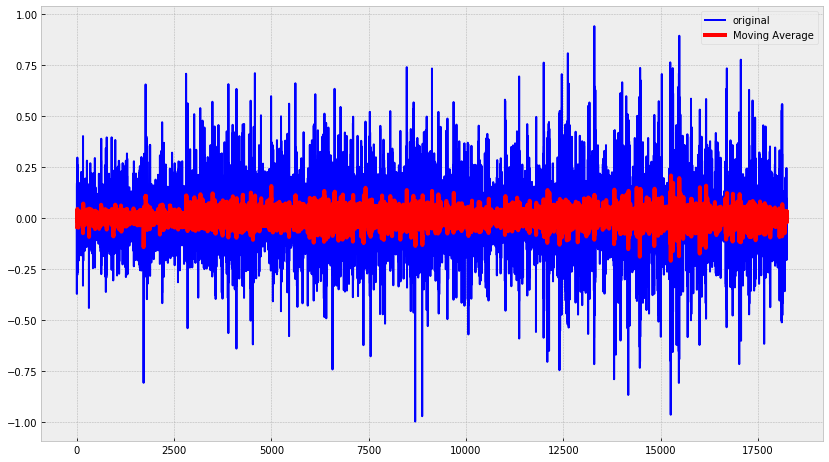

In [17]:
## Скользящее среднее

def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

ser = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

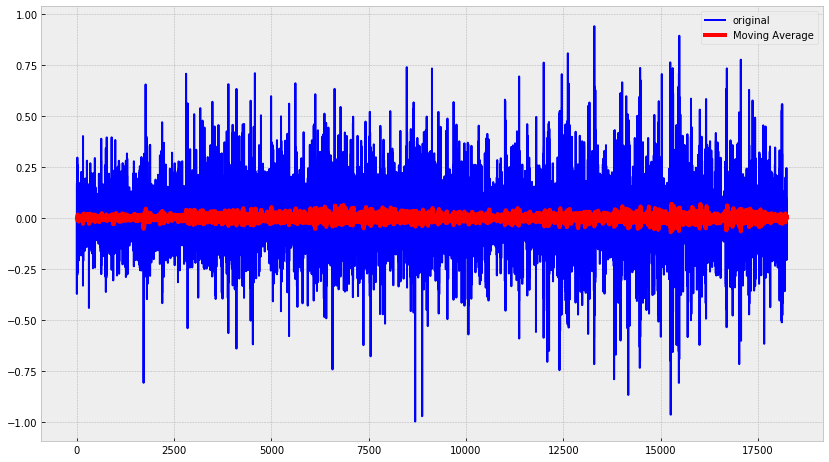

In [18]:
## Увеличим размер "окна" у скользящего среднего, тем самым уменьшив амплитуду колебаний

ser = moving_average(series, 20 )
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

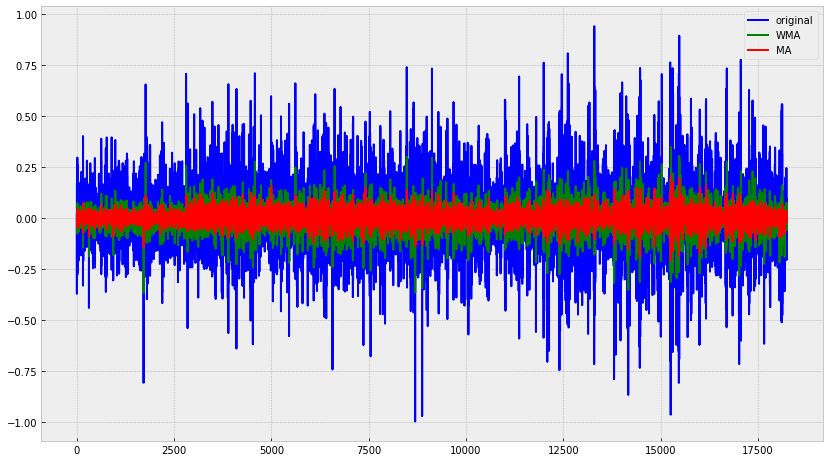

In [20]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return pd.Series([np.NaN]).append(wma, ignore_index=True)

wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.legend()

Обычное скользящее среднее "шумит" гораздо меньше, чем скользящее среднее с весами. В принципе, для стационарного ряда ввиду отсутствия сезонности, трендов и циклов достаточно обчного скользящего среднего. Можно еще больше увеличить размер окна.

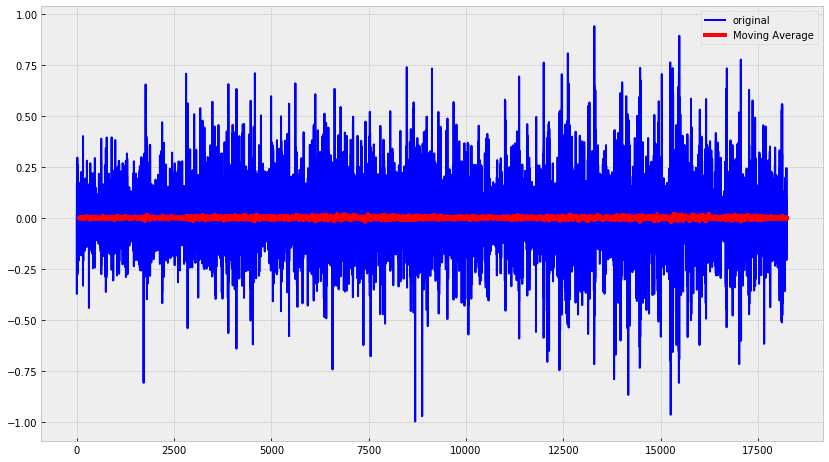

In [23]:
ser = moving_average(series, 70 )
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

### Приближение нестационарного ряда "Mean monthly air temperature"

In [24]:
series1 = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")['Deg']

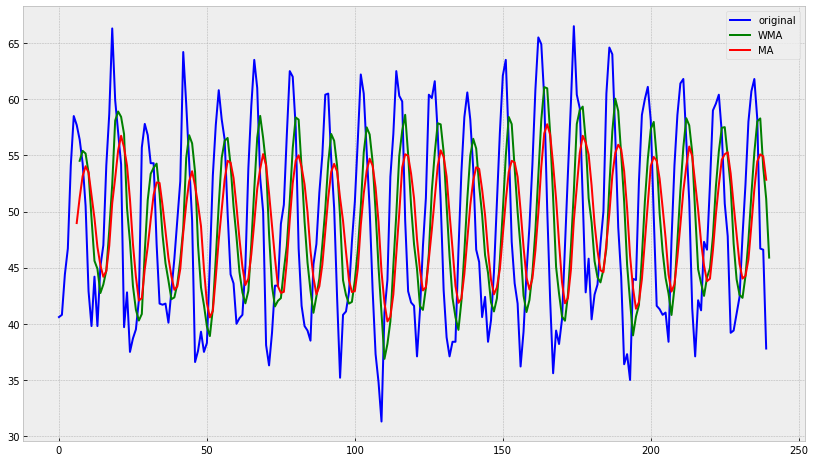

In [26]:
## Скользящее среднее уже не дает хороших результатов (например, из-за того, что сдвигает пики амплитуды)

wma = weighted_moving_average(series1, 7, [1,1,2,3,5,8,13])
ma = moving_average(series1, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.legend()

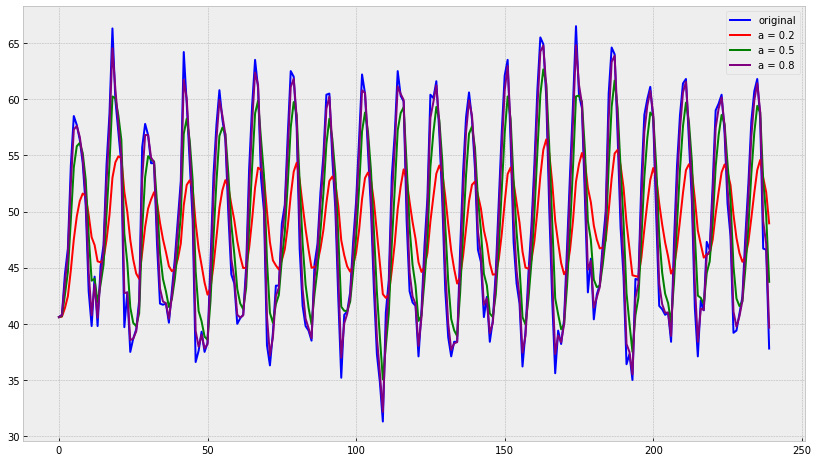

In [30]:
## Экспоненциальное сглаживание с разным альфа

def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

ema = exponential_moving_average(series1, 0.2)
ema1 = exponential_moving_average(series1, 0.5)
ema2 = exponential_moving_average(series1, 0.8)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue',label='original')
    plt.plot(ema, color='red', linewidth='2', label='a = 0.2')
    plt.plot(ema1, color='green', linewidth='2', label='a = 0.5')
    plt.plot(ema2, color='purple', linewidth='2', label='a = 0.8')
    plt.legend()

Экспоненциальное сглаживание с альфа = 0,9 больше всех приближено к оригинальному графику.

In [40]:
## Сглаживаем сезонную компоненту (тройное экспоненциальное сглаживание)

def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [41]:
def plot_tema(alpha, beta, gamma, ser=series1, ser_to_plot=series1, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

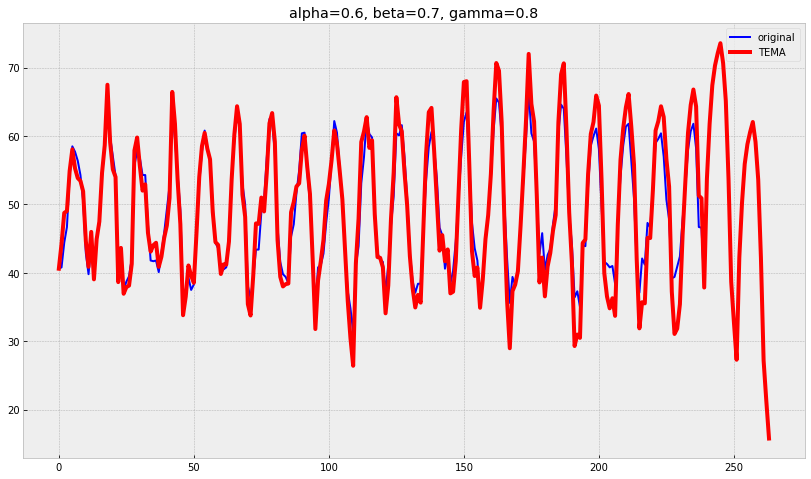

In [42]:
plot_tema(0.6, 0.7, 0.8)

In [47]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [45]:
train, test, val = series1[:60], series1[60:70], series1[70:]

In [48]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 7.386842500000012
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.96162054, 206.30222775,   0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([1., 0., 1.])


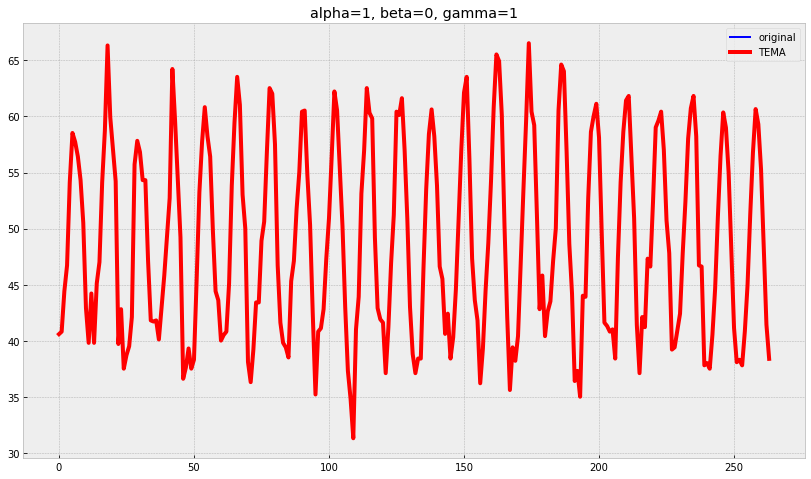

In [49]:
## Применим оптимальные параметры к модели тройного экспоненциального сглаживания

plot_tema(1, 0, 1)

Получили отличное приближение к оригинальной зависимости!